In [2]:
# -*- coding: utf-8 -*-
import os
import torch
import numpy as np
from torch.utils.data import Subset

import prepare_data as prepare_data
import partition_data as partition_data
import create_ood_test as create_ood_test

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["figure.facecolor"] = 'white'

In [3]:
# Hyperparameters.
data_type = "cifar10"  # cifar10
data_path = os.getcwd()
local_tr_ratio, local_te_ratio = 0.6, 0.2
non_iid_alpha = 0.1
seed = 6
random_state = np.random.RandomState(seed)
n_clients = 20
corr_severity = 5

# Sanity check.
assert local_tr_ratio > 0 and local_te_ratio >= 0

dataset = {}
if data_type == "cifar10":

    # Prepare dataset.
    dataset["cifar10_tr"] = prepare_data.get_dataset(
        data_name="cifar10", datasets_path=data_path, split="train",
    )
    dataset["cifar10_te"] = prepare_data.get_dataset(
        data_name="cifar10", datasets_path=data_path, split="test",
    )

    # Merge, then split.
    fl_data = torch.utils.data.ConcatDataset([dataset["cifar10_tr"], dataset["cifar10_te"]])
    fl_data.indices = list(range(len(dataset["cifar10_tr"]) + len(dataset["cifar10_te"])))
    fl_data.targets = dataset["cifar10_tr"].targets + dataset["cifar10_te"].targets

    non_iid_indices = partition_data.inter_client_non_iid_partition(
        fl_data, non_iid_alpha, random_state, n_clients
    )

    # Intra-split into local train/val/test.
    indices_per_client = partition_data.intra_client_uniform_partition(
        non_iid_indices, random_state, local_tr_ratio, local_te_ratio
    )

    # Create ID/OOD train & test datasets.
    fl_data_per_client = {}
    fl_data_per_client["train"], fl_data_per_client["val"], fl_data_per_client["test"] = {}, {}, {}
    for i, indices in indices_per_client.items():
        fl_data_per_client["train"][i] = Subset(fl_data, indices["train"])
        fl_data_per_client["val"][i] = Subset(fl_data, indices["val"])
        fl_data_per_client["test"][i] = Subset(fl_data, indices["test"])
    fl_data_per_client["corr_test"] = create_ood_test.get_corr_data(
        fl_data,
        indices_per_client,
        random_state,
        severity=corr_severity
    )  # common corruptions
    fl_data_per_client["ooc_test"] = create_ood_test.get_ooc_data(
        fl_data,
        indices_per_client,
        random_state,
    )  # out-of-client (label shift) test
    fl_data_per_client["natural_shift_test"] = create_ood_test.get_natural_shift_data(
        fl_data,
        indices_per_client,
        random_state,
        data_path=data_path,
        data_name="cifar10_1",
    )  # cifar10.1 (natural shift) test
    fl_data_per_client["mixed_test"] = create_ood_test.get_mixed_data(
        fl_data_per_client,
        random_state,
    )  # mixed test
else:
    raise NotImplementedError

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
CIFAR_CLASSES = ['plane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
SPLITS=["train", "val", "test", "corr_test", "ooc_test", "natural_shift_test", "mixed_test"]
TITLE={
    "train": "Train",
    "val": "Validation", 
    "test": "Test (in-distribution)", 
    "corr_test": "Corrupted test (common corruptions)", 
    "ooc_test": "Out-of-client test (label distribution shift)", 
    "natural_shift_test": "Naturally shifted test (cifar 10.1)" , 
    "mixed_test": "Mixture of ID/OOD tests",
    }

def plot_train_test_split(client_id):

    for split in SPLITS:
        data = fl_data_per_client[split][client_id]
        targets = [s[1] for s in data]
        cls, counts = np.unique(targets, return_counts=True)
        print(f"{split}: client {client_id} has class {list(cls)} with counts {list(counts)}")

    for split in SPLITS:
        data = fl_data_per_client[split][client_id]

        f, axes = plt.subplots(1, 10, figsize=(14, 2))
        plt.suptitle(f"client {client_id}: {TITLE[split]}", size=15)
        indices = random_state.choice(len(data), 10)
        for j, i in enumerate(indices):
            plt.axes(axes[j])
            xs, ys = data[i]
            plt.title(f'{CIFAR_CLASSES[ys]}', size=10)
            plt.imshow(xs.permute(1, 2, 0))
            plt.axis('off')



train: client 0 has class [1, 2, 4] with counts [14, 731, 1055]
val: client 0 has class [1, 2, 4] with counts [6, 254, 340]
test: client 0 has class [1, 2, 4] with counts [6, 247, 347]
corr_test: client 0 has class [1, 2, 4] with counts [6, 247, 347]
ooc_test: client 0 has class [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with counts [54, 56, 53, 63, 43, 66, 62, 73, 64, 66]
natural_shift_test: client 0 has class [2, 4] with counts [40, 59]
mixed_test: client 0 has class [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with counts [17, 25, 184, 24, 240, 15, 22, 31, 23, 19]


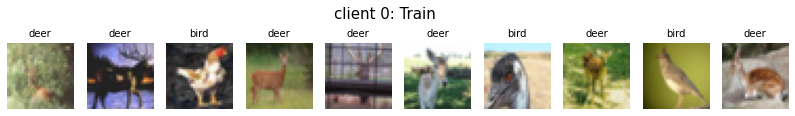

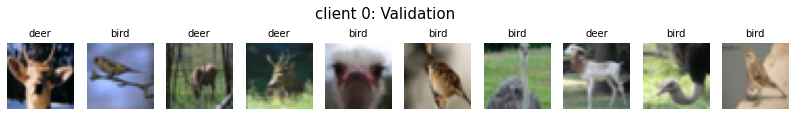

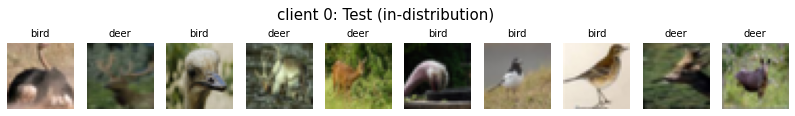

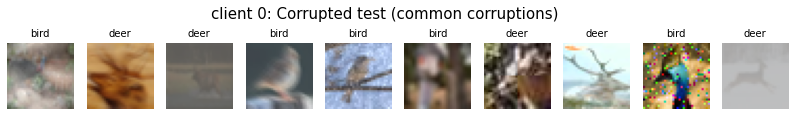

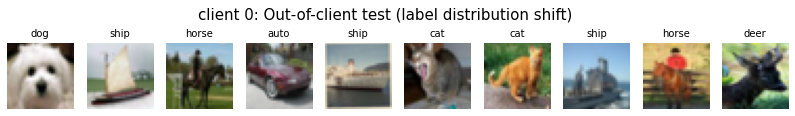

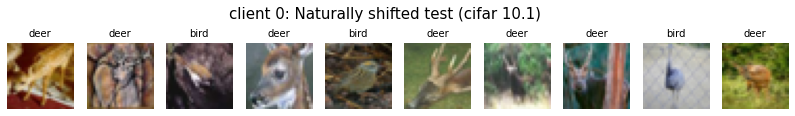

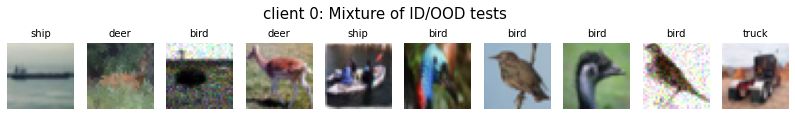

In [9]:
import warnings
warnings.simplefilter("ignore", FutureWarning)

plot_train_test_split(0)